In [1]:
!pip install -q torch transformers sentencepiece pandas scikit-learn openpyxl matplotlib

In [2]:
import torch
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

MODEL_NAME = "dreuxx26/Multilingual-grammar-Corrector-using-mT5-small"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME).to(device)
model.eval()

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/893 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/416 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'MT5Tokenizer'. 
The class this function is called from is 'T5Tokenizer'.
You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/763 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
          

In [6]:
import difflib

def predict_grammar_error(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=128,
            num_beams=4
        )

    corrected = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Compare original vs corrected
    diff = list(difflib.ndiff(sentence.split(), corrected.split()))

    for d in diff:
        if d.startswith("- ") or d.startswith("+ "):
            token = d[2:].strip()
            # ignore pure punctuation
            if re.fullmatch(r"[.,!?;:()]+", token):
                continue
            return 1

    return 0


Using device: cuda


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'MT5Tokenizer'. 
The class this function is called from is 'T5Tokenizer'.
/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Starting inference...


  0%|          | 0/15 [00:00<?, ?it/s]

Predicted incorrect samples: 387

Classification Report:
              precision    recall  f1-score   support

           0     0.9602    0.5940    0.7339       894
           1     0.0620    0.5217    0.1109        46

    accuracy                         0.5904       940
   macro avg     0.5111    0.5578    0.4224       940
weighted avg     0.9163    0.5904    0.7034       940



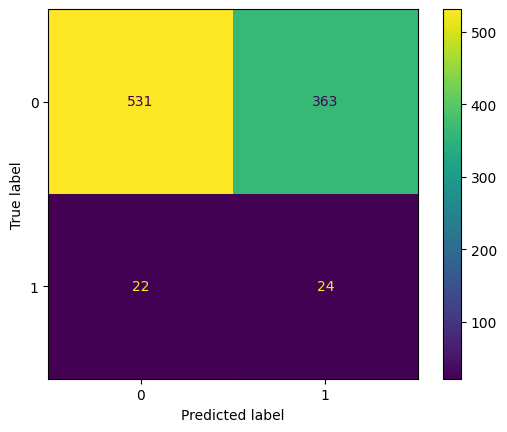

Saved to /content/mt5_grammar_detection_results.csv


In [8]:
import torch
import pandas as pd
import numpy as np
import re
import difflib
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

MODEL_NAME = "dreuxx26/Multilingual-grammar-Corrector-using-mT5-small"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME).to(device)

if device.type == 'cuda':
    model.half()
model.eval()

# Load Data
DATA_PATH = "/content/data_filtered.xlsx"
df = pd.read_excel(DATA_PATH, header=1)
sentences = df.iloc[:, 1].astype(str).tolist()
error_counts = df.iloc[:, 2].fillna(0).astype(int).values
gold_labels = np.array([1 if x > 0 else 0 for x in error_counts])

# Batch Processing Function
def get_batches(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i : i + batch_size]

# Logic to compare diffs
def check_diff(original, corrected):
    diff = list(difflib.ndiff(original.split(), corrected.split()))
    for d in diff:
        if d.startswith("- ") or d.startswith("+ "):
            token = d[2:].strip()
            if re.fullmatch(r"[.,!?;:()]+", token): # ignore punctuation changes
                continue
            return 1 # Found a grammatical error
    return 0 # No grammatical error

# Configuration
BATCH_SIZE = 64
pred_labels = []

print("Starting inference...")

# 4. Inference Loop
with torch.no_grad():
    for batch_sentences in tqdm(get_batches(sentences, BATCH_SIZE), total=len(sentences)//BATCH_SIZE + 1):

        # Tokenize the whole batch at once
        inputs = tokenizer(
            batch_sentences,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        ).to(device)

        # Generate for the whole batch
        outputs = model.generate(
            **inputs,
            max_length=128,
            num_beams=4
        )

        # Decode the whole batch
        corrected_batch = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Process diffs on CPU (Python logic)
        for original, corrected in zip(batch_sentences, corrected_batch):
            pred_labels.append(check_diff(original, corrected))

pred_labels = np.array(pred_labels)

# --- Reporting Results ---
print("Predicted incorrect samples:", pred_labels.sum())

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\nClassification Report:")
print(classification_report(gold_labels, pred_labels, digits=4))

cm = confusion_matrix(gold_labels, pred_labels)
ConfusionMatrixDisplay(cm).plot()
plt.show()

# Save
out_df = pd.DataFrame({
    "sentence": sentences,
    "gold_label": gold_labels,
    "pred_label": pred_labels
})
out_df.to_csv("/content/mt5_grammar_detection_results.csv", index=False)
print("Saved to /content/mt5_grammar_detection_results.csv")

In [ ]:
#@title Création d'un CSV dans le bon format, CSV contenant exclusivement des phrases correctes

import csv

phrases = [
    "phrase",
    "Le chat dort sur le rebord de la fenêtre.",
    "Nous partirons en randonnée demain matin.",
    "Elle a acheté trois livres à la librairie du coin.",
    "Les enfants jouent au parc après l'école.",
    "Il faut arroser les plantes toutes les semaines.",
    "La conférence commencera à neuf heures précises.",
    "J'aime écouter de la musique en travaillant.",
    "Le train arrive à la gare centrale à midi.",
    "Ils ont préparé un gâteau pour ton anniversaire.",
    "Le ciel est très clair ce soir, on voit les étoiles.",
    "Nous avons terminé le projet avant la date limite.",
    "Peux-tu fermer la fenêtre, il fait froid ici?",
    "Le médecin a recommandé un repos complet pendant une semaine.",
    "Son sourire a illuminé la pièce.",
    "Le restaurant propose des plats végétariens délicieux.",
    "Tous les documents sont classés dans le dossier rouge.",
    "Elle parle couramment trois langues étrangères.",
    "Ce film raconte une histoire vraie et émouvante.",
    "Le marché local vend des fruits frais chaque matin.",
    "Merci de confirmer votre présence par courriel."
]

with open("phrases.csv", mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    for phrase in phrases:
        # Première colonne vide, deuxième colonne avec la phrase
        writer.writerow(["", phrase])

print("Le fichier 'phrases.csv' a été généré avec succès.")

In [ ]:
#@title Ajout des étiquettes

import pandas as pd

df = pd.read_csv('/content/phrases.csv')
df['colonne3'] = "0"
df.to_csv('/content/file.csv', index=False)

print(f"Une troisième colonne a été ajoutée et remplie avec '0' pour {len(df)} lignes")
print(f"Colonnes actuelles : {df.columns.tolist()}")

In [10]:
#@title CSV to XLSX

import pandas as pd

# Chemin du fichier d'entrée et de sortie
csv_file = '/content/file.csv'
xlsx_file = '/content/file.xlsx'

try:
    # Lire le fichier CSV
    df = pd.read_csv(csv_file)

    # Convertir et sauvegarder en XLSX
    df.to_excel(xlsx_file, index=False, engine='openpyxl')

    print(f"✓ Conversion réussie !")
    print(f"  Fichier source : {csv_file}")
    print(f"  Fichier créé : {xlsx_file}")
    print(f"  Lignes : {len(df)}, Colonnes : {len(df.columns)}")

except FileNotFoundError:
    print(f"✗ Erreur : Le fichier {csv_file} n'existe pas")
except Exception as e:
    print(f"✗ Erreur lors de la conversion : {str(e)}")

✓ Conversion réussie !
  Fichier source : /content/file.csv
  Fichier créé : /content/file.xlsx
  Lignes : 20, Colonnes : 3


In [13]:
import torch
import pandas as pd
import numpy as np
import re
import difflib
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

MODEL_NAME = "dreuxx26/Multilingual-grammar-Corrector-using-mT5-small"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME).to(device)

if device.type == 'cuda':
    model.half()
model.eval()

# Load Data
DATA_PATH = "/content/file.xlsx"
df = pd.read_excel(DATA_PATH, header=1)
sentences = df.iloc[:, 1].astype(str).tolist()
error_counts = df.iloc[:, 2].fillna(0).astype(int).values
gold_labels = np.array([1 if x > 0 else 0 for x in error_counts])

# Batch Processing Function
def get_batches(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i : i + batch_size]

# Logic to compare diffs
def check_diff(original, corrected):
    diff = list(difflib.ndiff(original.split(), corrected.split()))
    for d in diff:
        if d.startswith("- ") or d.startswith("+ "):
            token = d[2:].strip()
            if re.fullmatch(r"[.,!?;:()]+", token): # ignore punctuation changes
                continue
            return 1 # Found a grammatical error
    return 0 # No grammatical error

# Configuration
BATCH_SIZE = 64
pred_labels = []

print("Starting inference...")

# Inference Loop
with torch.no_grad():
    for batch_sentences in tqdm(get_batches(sentences, BATCH_SIZE), total=len(sentences)//BATCH_SIZE + 1):

        # Tokenize the whole batch at once
        inputs = tokenizer(
            batch_sentences,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        ).to(device)

        # Generate for the whole batch
        outputs = model.generate(
            **inputs,
            max_length=128,
            num_beams=4
        )

        # Decode the whole batch
        corrected_batch = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Process diffs on CPU (Python logic)
        for original, corrected in zip(batch_sentences, corrected_batch):
            pred_labels.append(check_diff(original, corrected))

pred_labels = np.array(pred_labels)

print("Predicted incorrect samples:", pred_labels.sum())
print("\nClassification Report:")
print(classification_report(gold_labels, pred_labels, digits=4))

Using device: cuda


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'MT5Tokenizer'. 
The class this function is called from is 'T5Tokenizer'.
/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Starting inference...


  0%|          | 0/1 [00:00<?, ?it/s]

Predicted incorrect samples: 0

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        19

    accuracy                         1.0000        19
   macro avg     1.0000    1.0000    1.0000        19
weighted avg     1.0000    1.0000    1.0000        19

